# Merge multiple model after preprocessing

cf) baseline kernel: https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline
    모두의 딥러닝: http://www.yes24.com/Product/Goods/57736119?scode=032&OzSrank=1

## 1. Check Data

### import modules

In [15]:
import os
from os.path import join
from math import sqrt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn import svm
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### read data

In [6]:
test = pd.read_csv('./input/test.csv')
train = pd.read_csv('./input/train.csv')
print(test.shape, train.shape)
train.tail()

(6468, 20) (15035, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,15034,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


### Column Description

1. ID : 집을 구분하는 번호 
1. date : 집을 구매한 날짜 
1. price : 타겟 변수인 집의 가격 
1. bedrooms : 침실의 수
1. bathrooms : 침실당 화장실 개수
1. sqft_living : 주거 공간의 평방 피트
1. sqft_lot : 부지의 평방 피트
1. floors : 집의 층 수
1. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
1. view : 집이 얼마나 좋아 보이는지의 정도
1. condition : 집의 전반적인 상태
1. grade : King County grading 시스템 기준으로 매긴 집의 등급
1. sqft_above : 지하실을 제외한 평방 피트
1. sqft_basement : 지하실의 평방 피트
1. yr_built : 집을 지은 년도
1. yr_renovated : 집을 재건축한 년도
1. zipcode : 우편번호
1. lat : 위도
1. long : 경도
1. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
1. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [7]:
y = train['price']
del train['price'] # 가격을 별도로 저장 후, 원본에서 삭제

In [8]:
train_len = len(train) # 둘을 합치기 전에, 구분점(train의 길이)을 저장
data = pd.concat((train, test), axis=0)  # 합침

## 2. PreProcessing

### Missing Data

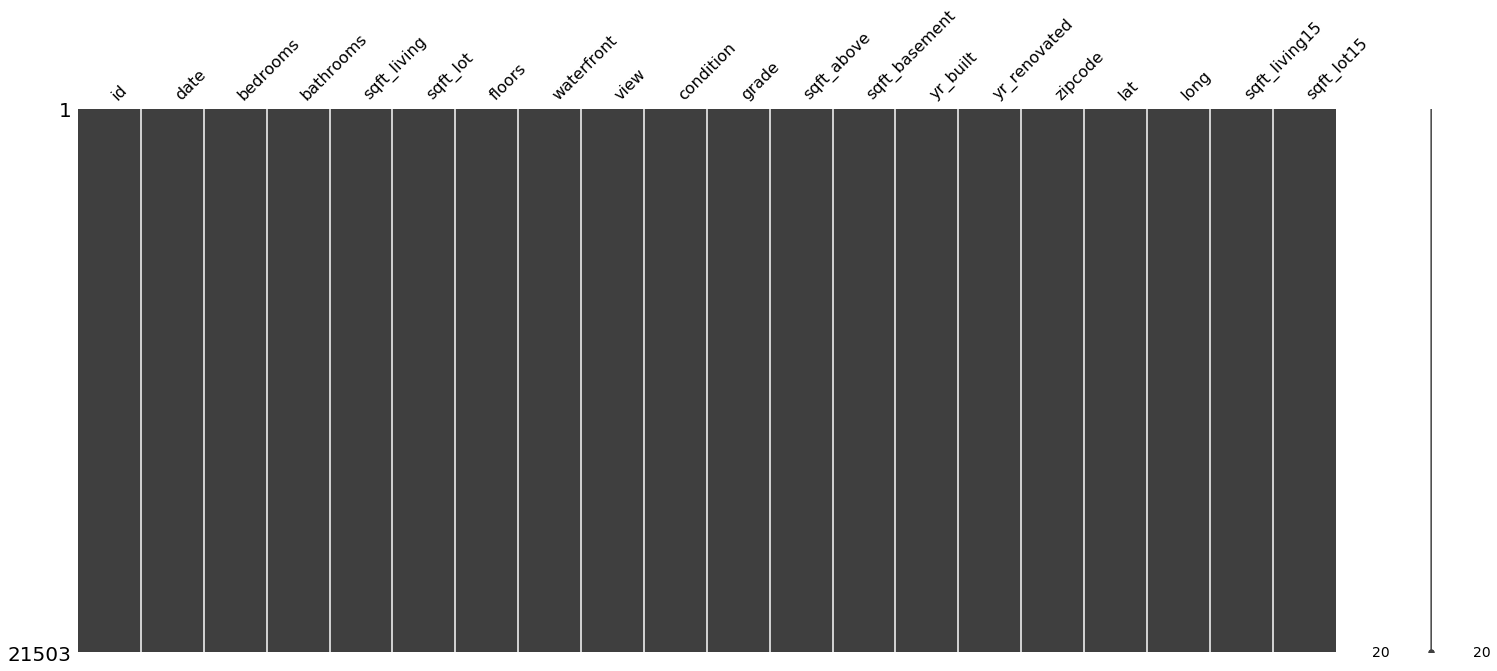

In [9]:
msno.matrix(data)

In [10]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]),c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### manipulate id,date

In [11]:
sub_id = data['id'][train_len:]
del data['id']

In [13]:
data['date'] = data['date'].apply(lambda x: str(x[:6])).astype(str)
print(len(data))
data.tail()

21503


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,201501,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


### Distribution

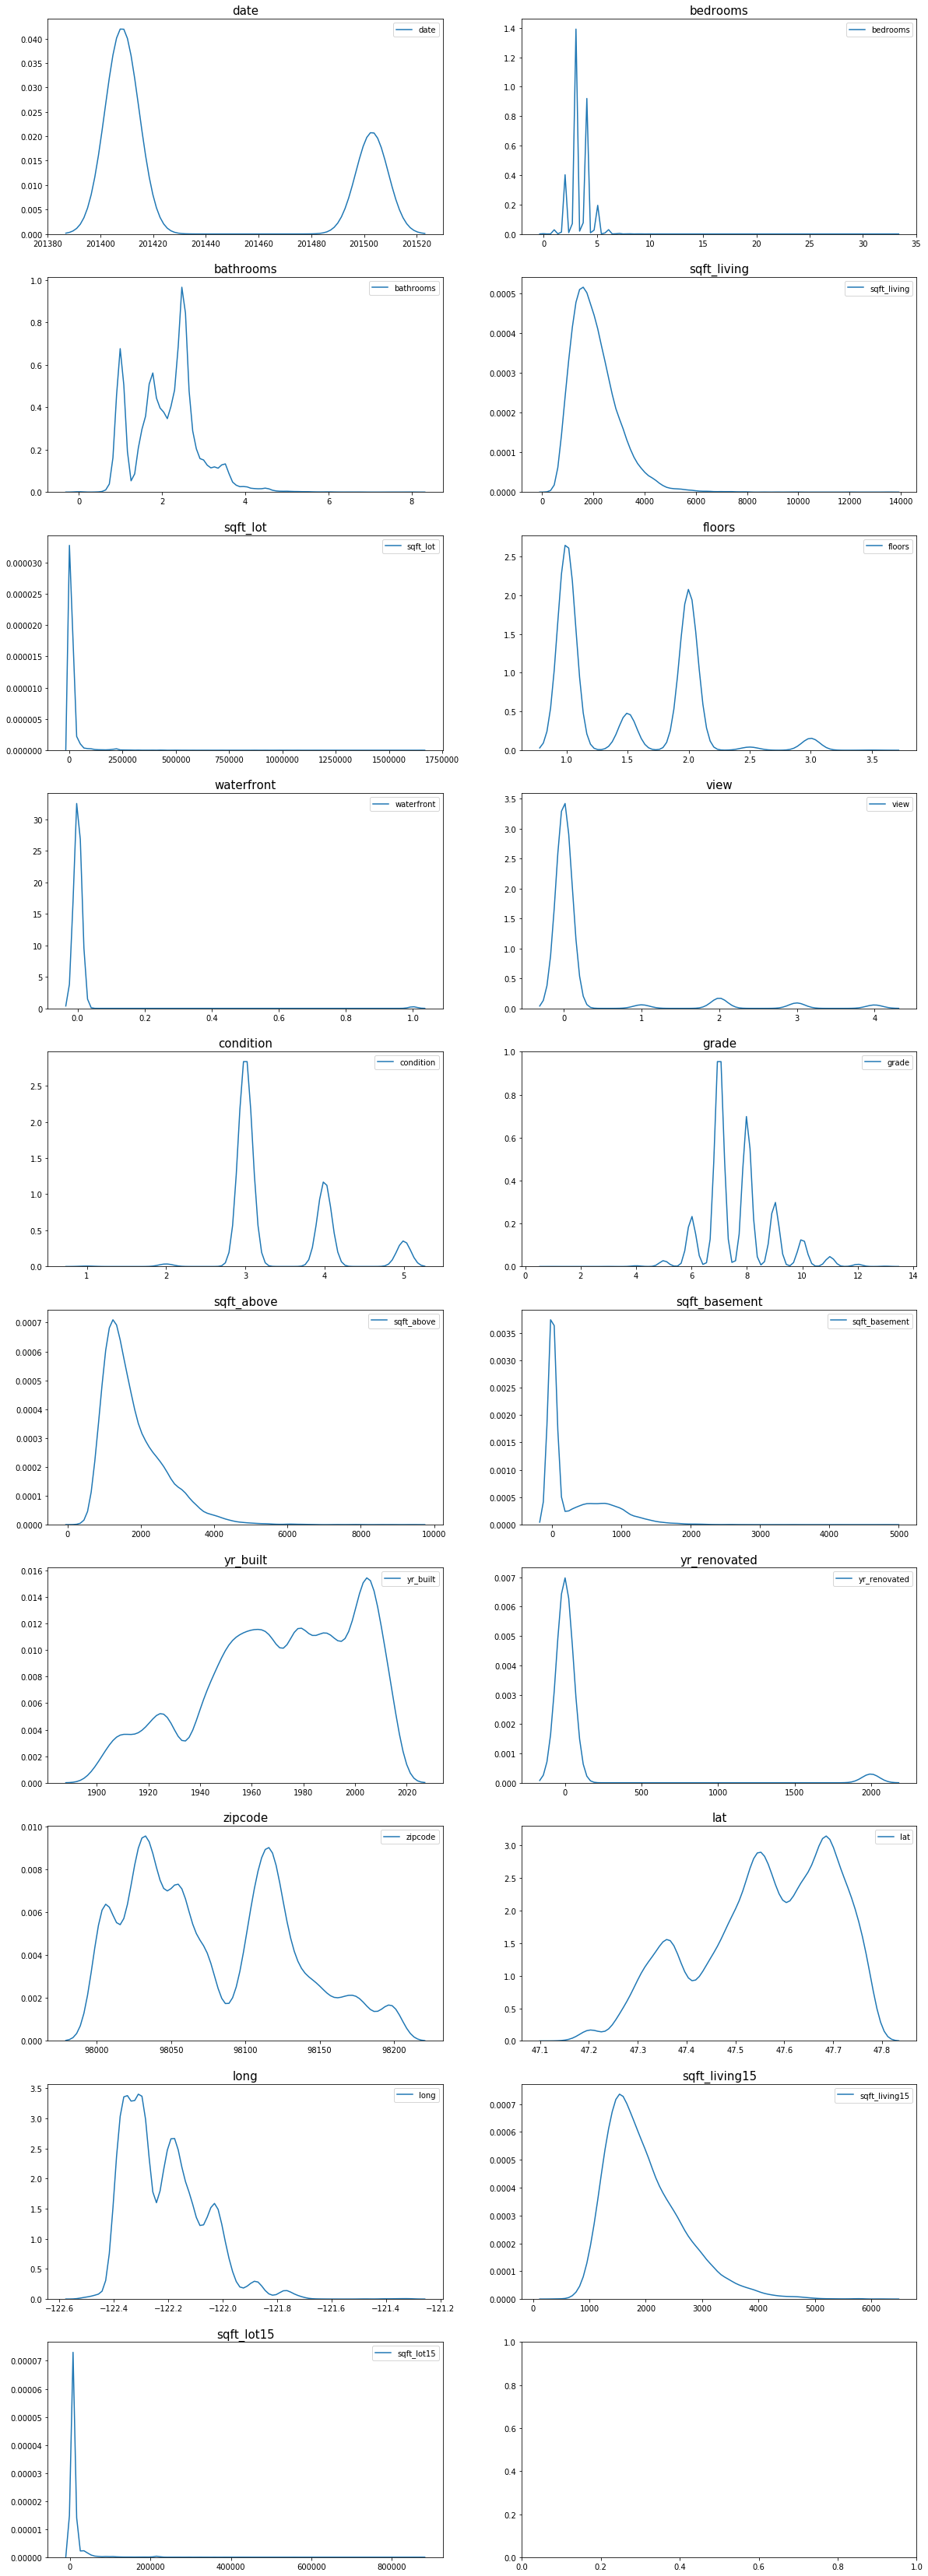

In [17]:
fig, ax = plt.subplots(10, 2, figsize=(20,60))

# ignore id column
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col]) # kernel density plot
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19:
            break

### apply log-scaling
price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 

In [18]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

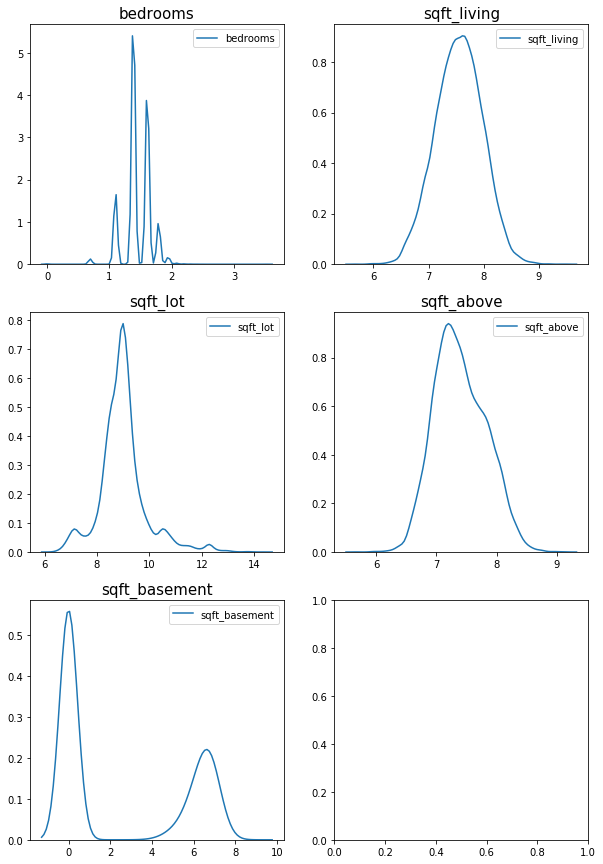

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

### divide data

In [20]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. Modeling

### Except Keras

In [21]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)
lasso = Lasso(alpha=1.0, random_state=2019)
svm = svm.SVC(kernel='rbf', C=1, gamma=0.1, random_state=2019)

models = [{'model':lightgbm, 'name':'LightGBM'},
          {'model':xgboost, 'name':'XGBoost'},
          {'model':gboost, 'name': 'GradientBoosting'},
          {'model':lasso, 'name': 'Lasso'},
          {'model':svm, 'name': 'SVM'}] # too slow and too low score

In [22]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), kf=kfold))

In [23]:
get_cv_score(models)

Model LightGBM CV score : 0.8749
Model XGBoost CV score : 0.8539
Model GradientBoosting CV score : 0.8573
Model Lasso CV score : 0.6643
Model SVM CV score : 0.0091


In [34]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
        
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [ ]:
y_pred = AveragingBlending(models, x, y, sub) # 다른 노트북 keras 학습이랑 같이 시키니까 커널 죽음... 

In [ ]:
sub = pd.DataFrame(data={'id':sub_id, 'price':y_pred})

In [ ]:
sub.to_csv('merge_5_models_after_preprocessing', index=False)

### Keras

In [24]:
# seed 값 설정
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.001, random_state=seed) # 15035개에서 0.001인 16개만 샘프롤 꺼냄
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(15019, 19) (16, 19) (15019,) (16,)


In [26]:
model = Sequential()
model.add(Dense(40, input_dim=19, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs=300, batch_size=10)

In [ ]:
# test_size =0.001, layer=(19,40,20,5,1) epoch=300, batch_size = 10, 학습속도: 9s, 최종 loss 489~~, 11자리
Y_prediction = model.predict(X_test).flatten()

# peek 5 samples

for i in range(5):
    label = Y_test[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f},      오차: {:.3f}".format(label, prediction, abs(label - prediction)))
RMSE = sqrt(mean_squared_error(label, prediction))
RMSE

In [ ]:
test_predict = model.predict(sub).flatten()

In [ ]:
sub = pd.DataFrame(data={'id':sub_id, 'price':test_predict})

In [ ]:
sub.to_csv('Keras_3rd_after_preprocessing.csv', index=False)